In this worksheet, the following are calculated:
1. Plot on map location of viable brackish water sites
2. Plot on map location of power plants 
3. % demand of a powerplant that can be met by all brackish wells within a state
4. % demand of a powerplant that can be met without exceeding a maximum LCOW


In [15]:
max_LCOW = 1.6  #$/m3
transport_cost = 0.0115   #$/m3/km

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import haversine as hs
import geopandas as gp
from shapely.geometry import Point, Polygon
import numpy as np

from pyomo.environ import Var, Expression, NonNegativeReals, Block, ConcreteModel, Constraint, Objective, Param, maximize, SolverFactory,RangeSet
import pyomo.environ as pyo
from idaes.core import FlowsheetBlock
from pyomo.environ import Block, Expression, units as pyunits
import math

Map brackish water sites that meet the following criteria
1. Well yield > 0.01
2. 0.5< TDS< 25 in kg/m3
3. Contiguous US states

LCOW calculated currently without transportation costs
File - brackish_sites_with_metrics

In [3]:
# bw_df = pd.read_csv('/Users/mhardika/Documents/AMO/GeoToolAll_Methods/Water Source Data/Brackish/brackish_sites_with_metrics.csv')
bw_df = pd.read_csv('/Users/mhardika/Documents/AMO/GeoToolAll_Methods/Water Source Data/Brackish/brackish_sites_with_metrics_baseline_dwi_updated_costs.csv')
netl_df = pd.read_csv("/Users/mhardika/Documents/AMO/GeoToolAll_Methods/Water Source Data/Power/NETL_ThermalPlants_Filtered.csv")

Updating powerplant dataframe to group demand with the same plant code (independent of fuel)\
Filter powerplants where freshwater is used and where all the data is available --> this filter is copied from previous files

In [4]:
pp_df = netl_df[((netl_df.WaterType == 'Fresh') & (netl_df.WAvg != '...') & (netl_df.WAvg != '---'))]
pp_group= pp_df.groupby('PlantCode')
pp_df.WAvg = pp_df.WAvg.astype(float)
cols= ['PlantCode','Demand_m3/s','PPLatitude','PPLongitude']

pp_combined_df = pd.DataFrame(columns = cols)
pp_group= pp_df.groupby('PlantCode')

for key in pp_group.groups.keys():

    demand = sum((pp_group.get_group(key).WAvg * 0.0037854 / 3600) * pp_group.get_group(key).Capacity)
    # pp_combined_df = pp_combined_df.append
    temp_dict = {'PlantCode':key,
                 'PlantState':pp_group.get_group(key)['PlantState'].values[0],
                 'Demand_m3/s': demand ,
                 'PPLatitude':pp_group.get_group(key)['Latitude'].values[0],
                 'PPLongitude':pp_group.get_group(key)['Longitude'].values[0]}
    
    temp = pd.DataFrame(temp_dict,index= [0])                  
    pp_combined_df = pd.concat([pp_combined_df,temp],ignore_index=True)
    pp_combined_df.reset_index()


C:\Users\mhardika\AppData\Local\Temp\1\ipykernel_16064\3971423114.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pp_df.WAvg = pp_df.WAvg.astype(float)


A sample map for Texas

In [85]:
pp_combined_df

,PlantCode,Demand_m3/s,PPLatitude,PPLongitude,PlantState
0,3,57.648886,31.00690,-88.0103,AL
1,7,6.407161,34.01280,-85.9708,AL
2,10,32.119974,32.60170,-87.7811,AL
3,26,64.158101,33.24421,-86.4581,AL
4,46,157.248722,34.70420,-87.1189,AL
...,...,...,...,...,...
442,60376,0.202900,41.14889,-80.8516,OH
443,60589,0.246291,40.41200,-78.8550,PA
444,60768,0.146787,32.97500,-112.6940,AZ
445,60926,0.273370,30.01000,-90.4608,LA


In [30]:
texas = gp.read_file('/Users/mhardika/Documents/AMO/GeoToolAll_Methods/GeoData/Texas Counties Map/geo_export_c05b3355-1638-4e46-b56c-ac18de751ed8.shp')
texas = texas.to_crs("EPSG:4326")


In [31]:
bw_long = bw_df[bw_df['state_alpha']=='TX']['Longitude']
bw_lat = bw_df[bw_df['state_alpha']=='TX']['Latitude']

bw_geometry = [Point(xy) for xy in zip(bw_long,bw_lat)]
bw_geo_df = gp.GeoDataFrame(geometry = bw_geometry, crs='EPSG:4326')
bw_geo_df.geometry = bw_geo_df.geometry.to_crs('EPSG:4326')
bw_geo_df = bw_geo_df.assign(county_nm = bw_df[bw_df['state_alpha'] =='TX']['county_nm'].values)

pp_long = pp_combined_df[pp_combined_df['PlantState']=='TX']['PPLongitude']
pp_lat = pp_combined_df[pp_combined_df['PlantState']=='TX']['PPLatitude']

pp_geometry = [Point(xy) for xy in zip(pp_long,pp_lat)]
pp_geo_df = gp.GeoDataFrame(geometry = pp_geometry, crs='EPSG:4326')
pp_geo_df.geometry = pp_geo_df.geometry.to_crs('EPSG:4326')


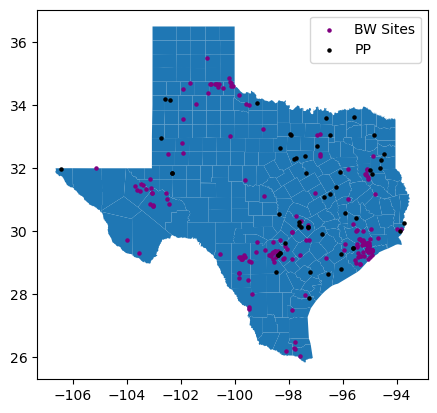

In [32]:
fig, ax = plt.subplots()
# states[states['NAME'] == 'Texas'].plot(ax=ax,figsize=(20, 20))
texas.plot(ax=ax,figsize=(50, 50))
bw_geo_df.plot(ax=ax, color='purple', markersize = 5,label = "BW Sites")
pp_geo_df.plot(ax=ax, color='black', markersize = 5,label='PP')

ax.legend()

Selecting brackish water sites for powerplants
1. Minimize cost for the state
2. Does not exceed the capacity of each brackish water site

In [16]:
# Create matrix of brackish water sites (rows) and powerplant (columns) distance
from pyomo.environ import Var, Expression, NonNegativeReals, Block, ConcreteModel, Constraint, Objective, Param, maximize, SolverFactory,RangeSet
import pyomo.environ as pyo
from idaes.core import FlowsheetBlock
from pyomo.util.infeasible import *
from idaes.core.util.model_statistics import *

bw_state_df = bw_df[bw_df['state_alpha']=='TX']
bw_state_df = bw_state_df.set_index('unique_site_ID')

pp_state_df =  pp_combined_df[pp_combined_df['PlantState']=='TX']
pp_state_df = pp_state_df.set_index('PlantCode')

no_bw_sites = len(bw_state_df)
no_pp_sites = len(pp_state_df)

dist = np.zeros((no_bw_sites,no_pp_sites))
pp_demand = []
# Create array with brackish water availability
bw_vol = []
LCOW = []
plantcode=[]

i = 0
j = 0 

for pp in pp_state_df.index:
    pp_long = pp_state_df['PPLongitude'].loc[pp]
    pp_lat = pp_state_df['PPLatitude'].loc[pp]

    pp_loc = (pp_lat,pp_long)    
    pp_demand.append(pp_state_df['Demand_m3/s'].loc[pp])

    plantcode.append(pp)
    j=0
    for site in bw_state_df.index:
        bw_long = bw_state_df['Longitude'].loc[site]
        bw_lat = bw_state_df['Latitude'].loc[site]

        bw_loc = (bw_lat,bw_long)
        dist_km = hs.haversine(pp_loc,bw_loc)
        
        if dist_km >= 100:
            dist[j,i] = 1e10
        else:
            dist[j,i] = dist_km
        j=j+1

    i=i+1


for site in bw_state_df.index:
    bw_available = bw_state_df['well_yield'].loc[site]*bw_state_df['recovery'].loc[site]/100
    bw_vol.append(bw_available)

    lcow = bw_state_df['lcow'].loc[site]
    LCOW.append(lcow)


def transport_cost(bw_vol,dist):
    transport_lcow_pipe = pipe_costing(bw_available*3600*24,dist_km*1.6)
    transport_lcow_truck = truck_costing(dist_km*1.6)

    transport_lcow = min(transport_lcow_pipe,transport_lcow_truck)
    return float(transport_lcow)


def try_cool_matrix(bw_vol,demand,lcow,dist):

    m = ConcreteModel()
    m.I = pyo.Set(initialize = range(dist.shape[0]))
    # powerplant site index
    m.J = pyo.Set(initialize = range(dist.shape[1]))

    m.matrix= pyo.Set(initialize = m.I*m.J)
    m.x = Var(m.matrix, domain=NonNegativeReals, bounds= (0,1))

    m.constraints= pyo.ConstraintList()

    # Sum of fractions should be less than or equal to 1
    for i in m.I:
        m.constraints.add((sum(m.x[i,j] for j in m.J)) <= 1 )

    # Production to be as close to maximum as possible
    for j in m.J:
       m.constraints.add((sum(m.x[i,j]*float(bw_vol[i]) for i in m.I)) >= demand[j])

    # for j in m.J:
    #     m.constraints.add((sum(( LCOW[i]*m.x[i,j] + transport_cost(bw_vol[i],dist[i,j])*m.x[i,j] ) for i in m.I)) <= 1.4)

    # def obj_demand(m):
    #     return sum(sum(m.x[i,j]*float(bw_vol[i]) for i in m.I) for j in m.J)
    

    # LCOW objective
    def obj(m):
        return sum(sum((LCOW[i]*m.x[i,j] + transport_cost(bw_vol[i],dist[i,j])*m.x[i,j]) for i in m.I) for j in m.J)


    # m.obj2 = Objective(rule=obj_demand,sense = pyo.maximize)
    m.obj1 = Objective(rule = obj)

    solver = SolverFactory('ipopt')
    results = solver.solve(m)
    

    # for constr in m.component_data_objects(ctype=Constraint, active=True, descend_into=True):
    #     tol=1E-6
    #     constr_body_value = value(constr.body, exception=False)
    #     constr_lb_value = value(constr.lower, exception=False)
    #     if constr_body_value is None:
    #             # Undefined constraint body value due to missing variable value
    #         constr_undefined = True
    #         pass
    #     else:
    #         # Check for infeasibilities
    #         if constr.equality:
    #             if fabs(constr_lb_value - constr_body_value) >= tol:
    #                 equality_violated = True
    #                 constr.deactivate()

    # results = solver.solve(m)
    # for constraint in m.

    return m


c:\Users\mhardika\miniconda3\envs\watertap3\lib\site-packages\pandas\core\indexes\base.py:6999: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
  return Index(sequences[0], name=names)


In [9]:
print(pp_demand)

[0.4373309107049999, 0.99563090590935, 61.25471179484999, 0.34036748613929996, 32.849312145000006, 0.35078351258721, 116.39452529529, 0.31968687077820007, 18.31458070134, 45.57130595766, 11.450835, 35.500732831994995, 27.189233593199997, 30.63274080768, 15.65136476052, 15.30025040412, 45.087215925, 109.79837866799998, 121.36178294685, 27.60030752895, 60.372939089025, 62.00916640965001, 0.2945632679265, 0.6359000019504001, 105.7258339965, 0.19362181276680002, 70.0599100203, 11.70011404191, 0.0902536720488, 25.8946396215, 0.0855712363473, 0.22497017049, 0.115451038603395, 0.11726352878490001, 0.1191669940419, 0.24952547933625005, 0.19036328650485, 0.24646130245019998, 11.9091049875, 0.14817812656499998, 0.19599825281820002, 0.31574678829345, 0.2663058186378, 0.33503315681970003, 0.19591269878249998, 0.16381458875250005, 0.3326319812823, 0.07392045, 0.12382913177666999, 0.1568179639026, 0.214885240709085, 0.15786817915887]


In [18]:
def update_demand(supply_max,demand):
    for i in range(0,len(demand)):
        if demand[i]>supply_max:
            demand[i]=supply_max
    return demand

supply_max = sum(bw_vol)/len(bw_vol)

demand = update_demand(supply_max,pp_demand)

m = try_cool_matrix(bw_vol,pp_demand,LCOW,dist)
# m.display()
dict = (m.x.get_values())

x = np.zeros(dist.shape)
print(x)
for i,j in dict.keys():
    x[i,j] = dict[(i,j)]

# print(x)

supply = bw_vol*x[:,0]

# print(sum(supply))
# print(pp_demand[0])
# print(sum(supply)/pp_demand[0]*100)
# print(plantcode[0])

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


In [58]:
# figure out how to deactivate infeasible constraints
from idaes.core.util.model_statistics import *

for constr in m.component_data_objects(ctype=Constraint, active=True, descend_into=True):
    tol=1E-6
    constr_body_value = value(constr.body, exception=False)
    constr_lb_value = value(constr.lower, exception=False)
    if constr_body_value is None:
            # Undefined constraint body value due to missing variable value
        constr_undefined = True
        pass
    else:
        # Check for infeasibilities
        if constr.equality:
            if fabs(constr_lb_value - constr_body_value) >= tol:
                equality_violated = True
    constr.deactivate()

In [59]:
dfx = pd.DataFrame(x)
bw_vol=np.array(bw_vol)
# print((pp_demand))
print(x[:,0])
# log_infeasible_constraints(m)
# print(x.shape)
# print(bw_vol.shape)
# np.matmul(bw_vol,x)

[0.00400447 0.0048171  0.0056255  0.00683315 0.00740414 0.00764394
 0.00778857 0.00794573 0.0080443  0.00839408 0.00844992 0.0088246
 0.00892953 0.00901114 0.00893027 0.00908874 0.00932345 0.00938286
 0.00979599 0.00968495 0.00975029 0.00990955 0.01013334 0.01038881
 0.01057142 0.01076096 0.0106613  0.01072232 0.01067348 0.01104663
 0.01100734 0.01152367 0.01140274 0.01170726 0.01178798 0.01193449
 0.01198119 0.01205988 0.012113   0.01235584 0.0122567  0.0123298
 0.01239798 0.01248731 0.01249818 0.01274276 0.01259096 0.0126278
 0.01265993 0.01273642 0.01274799 0.01280289 0.01286809 0.01282412
 0.01288964 0.01289036 0.01303174 0.01292148 0.01288497 0.01331462
 0.01297183 0.01304279 0.01292357 0.01319834 0.01298134 0.01305527
 0.01307732 0.01303774 0.01291492 0.01319298 0.01290596 0.01290641
 0.01345361 0.01292551 0.01321439 0.01339485 0.01321882 0.01365281
 0.01363342 0.01347849 0.01364973 0.01349264 0.01373191 0.01359784
 0.01384652 0.01375741 0.01372983 0.01385068 0.01389842 0.0138901

Powerplant % Demand met
1. Assuming multiple brackish water sites provide to a single powerplant
2. Adding transportation cost to LCOW based on the value in variable transport_cost
3. No limitation on maximum distance

Creating a dataframe with one powerplant to many brackish water sites and respective distances.\
Sorting in order of increasing distance.\
Calculating demand met with every brackish water site and weighted tLCOW (LCOW which includes transport costs )

In [33]:
bw_state_df = bw_df[bw_df['state_alpha']=='TX']
bw_state_df = bw_state_df.set_index('unique_site_ID')

pp_state_df =  pp_combined_df[pp_combined_df['PlantState']=='TX']
pp_state_df = pp_state_df.set_index('PlantCode')

c:\Users\mhardika\miniconda3\envs\watertap3\lib\site-packages\pandas\core\indexes\base.py:6999: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
  return Index(sequences[0], name=names)


In [34]:
cols = ['PlantCode','PPLatitude','PPLongitude','PPDemand','BWSites','BWLatitude','BWLongitude','BWAvailable','Distance_km',
        'PPDemandFracMet','LCOW','TransportLCOW','tLCOW','WeightedtLCOW','Cum_PPDemandFracMet']

one_pp_many_bw_df  = pd.DataFrame(columns=cols)

for pp in pp_state_df.index:
    pp_long = pp_state_df['PPLongitude'].loc[pp]
    pp_lat = pp_state_df['PPLatitude'].loc[pp]

    pp_loc = (pp_lat,pp_long)    

    plantcode = pp
    
    for site in bw_state_df.index:
        bw_long = bw_state_df['Longitude'].loc[site]
        bw_lat = bw_state_df['Latitude'].loc[site]

        bw_loc = (bw_lat,bw_long)
        dist_km = hs.haversine(pp_loc,bw_loc)
        
        bw_available = bw_state_df['well_yield'].loc[site]*bw_state_df['recovery'].loc[site]/100
        pp_demand_frac_met = bw_available/pp_state_df['Demand_m3/s'].loc[pp]
        lcow = bw_state_df['lcow'].loc[site]

        # Updated transport costs
        
        transport_lcow_pipe = pipe_costing(bw_available*3600*24,dist_km*1.6)
        transport_lcow_truck = truck_costing(dist_km*1.6)

        transport_lcow = min(transport_lcow_pipe,transport_lcow_truck)
        # transport_onm = transport_cost*dist_km*bw_available*365*24*3600
        # tlcow = (lcow*bw_available*365*24*3600 + transport_onm)/(bw_available*365*24*3600) 
        tlcow = lcow + transport_lcow
        
        temp_dict =  {'PlantCode' : pp,
                      'PPLatitude' : pp_lat,
                      'PPLongitude' : pp_long,
                      'PPDemand' : pp_state_df['Demand_m3/s'].loc[pp],
                      'BWSites' : site,
                      'BWLatitude' : bw_lat,
                      'BWLongitude' : bw_long,
                      'BWAvailable' : bw_available,
                      'Distance_km' : dist_km,
                      'PPDemandFracMet' : pp_demand_frac_met,
                      'LCOW' : lcow,
                      'TransportLCOW' : transport_lcow,
                      'tLCOW' : tlcow,
                      'WeightedtLCOW': 0,
                      'Cum_PPDemandFracMet': 0}
        
        temp = pd.DataFrame(temp_dict,index= [0])    
        one_pp_many_bw_df = pd.concat([one_pp_many_bw_df,temp],ignore_index=True)
        one_pp_many_bw_df.reset_index()

one_pp_many_bw_df_sorted1 = one_pp_many_bw_df.sort_values(['PlantCode','tLCOW']).groupby('PlantCode')
one_pp_many_bw_df_sorted2 = one_pp_many_bw_df.sort_values(['PlantCode','Distance_km']).groupby('PlantCode')

one_pp_many_bw_df

,PlantCode,PPLatitude,PPLongitude,PPDemand,BWSites,BWLatitude,BWLongitude,BWAvailable,Distance_km,PPDemandFracMet,LCOW,TransportLCOW,tLCOW,WeightedtLCOW,Cum_PPDemandFracMet
0,127,34.08250,-99.1753,0.437331,FETH-261730N0974730.1,26.291667,-97.791694,0.050873,876.418788,0.116327,0.948076,24.426976,25.375052,0,0
1,127,34.08250,-99.1753,0.437331,FETH-262920N0974650.1,26.488889,-97.780583,0.057710,854.895038,0.131959,0.899614,22.286369,23.185983,0,0
2,127,34.08250,-99.1753,0.437331,FETH-291610N1003320.1,29.269444,-100.555583,0.039780,550.876896,0.090962,1.003341,17.528924,18.532265,0,0
3,127,34.08250,-99.1753,0.437331,FETH-292140N0950400.1,29.361111,-95.066694,0.103586,653.019369,0.236860,0.782495,12.563978,13.346473,0,0
4,127,34.08250,-99.1753,0.437331,FETH-311340N0970030.1,31.227778,-97.008361,0.046238,376.691923,0.105728,1.020368,11.100008,12.120376,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10239,58005,33.58257,-96.6179,0.157868,USGS-305112102265901,30.853411,-102.449654,0.015612,626.796772,0.098894,1.205917,33.306520,34.512437,0,0
10240,58005,33.58257,-96.6179,0.157868,USGS-305318103080401,30.881399,-103.135300,0.044614,682.453872,0.282602,0.881049,20.414354,21.295403,0,0
10241,58005,33.58257,-96.6179,0.157868,USGS-310136102311601,31.026699,-102.521019,0.062086,623.203271,0.393276,0.883620,15.654238,16.537859,0,0
10242,58005,33.58257,-96.6179,0.157868,USGS-311340103040101,31.227920,-103.067657,0.059146,659.514038,0.374656,0.835556,16.995126,17.830682,0,0


In [35]:
one_pp_many_bw_df = one_pp_many_bw_df_sorted1.apply(pd.DataFrame).set_index('PlantCode')
weighted_lcow = []
cum_pp_demand_frac_met = []

for pp in pp_state_df.index:
    cum_bw_available = np.array(one_pp_many_bw_df['BWAvailable'].loc[pp].cumsum())
    cum_cost = np.array((one_pp_many_bw_df['BWAvailable'].loc[pp]*one_pp_many_bw_df['tLCOW'].loc[pp]).cumsum())
    temp = np.divide(cum_cost,cum_bw_available)
    weighted_lcow = np.append(weighted_lcow, temp,axis=0)
    temp_demand_met = np.array(one_pp_many_bw_df['PPDemandFracMet'].loc[pp].cumsum())
    cum_pp_demand_frac_met = np.append(cum_pp_demand_frac_met,temp_demand_met,axis=0)

one_pp_many_bw_df['WeightedtLCOW'] = weighted_lcow
one_pp_many_bw_df['Cum_PPDemandFracMet'] = cum_pp_demand_frac_met
one_pp_many_bw_df.head()

c:\Users\mhardika\miniconda3\envs\watertap3\lib\site-packages\pandas\core\indexes\base.py:6999: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
  return Index(sequences[0], name=names)


,PPLatitude,PPLongitude,PPDemand,BWSites,BWLatitude,BWLongitude,BWAvailable,Distance_km,PPDemandFracMet,LCOW,TransportLCOW,tLCOW,WeightedtLCOW,Cum_PPDemandFracMet
PlantCode,,,,,,,,,,,,,,
127,34.0825,-99.1753,0.437331,NURE-OR16109,34.020000,-99.469000,0.057650,27.936577,0.131823,0.819871,0.806176,1.626047,1.626047,0.131823
127,34.0825,-99.1753,0.437331,NURE-OR16158,34.053000,-99.573000,0.058716,36.779215,0.134260,0.767700,1.036244,1.803943,1.715810,0.266084
127,34.0825,-99.1753,0.437331,NURE-OR16172,34.324000,-99.850000,0.050918,67.609434,0.116429,0.898852,1.968418,2.867270,2.066291,0.382513
127,34.0825,-99.1753,0.437331,NURE-OR11673,34.622000,-100.132000,0.068157,106.357724,0.155849,0.832107,2.617541,3.449649,2.466755,0.538361
127,34.0825,-99.1753,0.437331,FETH-343700N1000430.1,34.616667,-100.075028,0.051104,101.736460,0.116854,0.895185,2.908056,3.803241,2.705110,0.655215


In [63]:
one_pp_many_bw_df = one_pp_many_bw_df_sorted2.apply(pd.DataFrame).set_index('PlantCode')
weighted_lcow = []
cum_pp_demand_frac_met = []

for pp in pp_state_df.index:
    cum_bw_available = np.array(one_pp_many_bw_df['BWAvailable'].loc[pp].cumsum())
    cum_cost = np.array((one_pp_many_bw_df['BWAvailable'].loc[pp]*one_pp_many_bw_df['tLCOW'].loc[pp]).cumsum())
    temp = np.divide(cum_cost,cum_bw_available)
    weighted_lcow = np.append(weighted_lcow, temp,axis=0)
    temp_demand_met = np.array(one_pp_many_bw_df['PPDemandFracMet'].loc[pp].cumsum())
    cum_pp_demand_frac_met = np.append(cum_pp_demand_frac_met,temp_demand_met,axis=0)

one_pp_many_bw_df['WeightedtLCOW'] = weighted_lcow
one_pp_many_bw_df['Cum_PPDemandFracMet'] = cum_pp_demand_frac_met
one_pp_many_bw_df.head()

c:\Users\mhardika\miniconda3\envs\watertap3\lib\site-packages\pandas\core\indexes\base.py:6999: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
  return Index(sequences[0], name=names)


,PPLatitude,PPLongitude,PPDemand,BWSites,BWLatitude,BWLongitude,BWAvailable,Distance_km,PPDemandFracMet,LCOW,TransportLCOW,tLCOW,WeightedtLCOW,Cum_PPDemandFracMet
PlantCode,,,,,,,,,,,,,,
127,34.0825,-99.1753,0.437331,NURE-OR16109,34.020000,-99.469000,0.056282,27.936577,0.128694,0.713040,0.815811,1.528851,1.528851,0.128694
127,34.0825,-99.1753,0.437331,NURE-OR16158,34.053000,-99.573000,0.057844,36.779215,0.132265,0.678675,1.044045,1.722720,1.627112,0.260959
127,34.0825,-99.1753,0.437331,NURE-OR16172,34.324000,-99.850000,0.049316,67.609434,0.112766,0.770620,2.000921,2.771541,1.972427,0.373726
127,34.0825,-99.1753,0.437331,NURE-OR21107,33.244000,-98.938000,0.011098,95.788587,0.025376,1.119999,6.324450,7.444448,2.320356,0.399102
127,34.0825,-99.1753,0.437331,FETH-343700N1000430.1,34.616667,-100.075028,0.049504,101.736460,0.113196,0.767580,2.956103,3.723683,2.630431,0.512298


Map the maximum % demand that be potentially met with all brackish water sites

In [41]:
plantcodes = list(one_pp_many_bw_df.groupby('PlantCode').groups.keys())
pp_geo_df.index = plantcodes

Text(0.5, 1.0, 'Average LCOW')

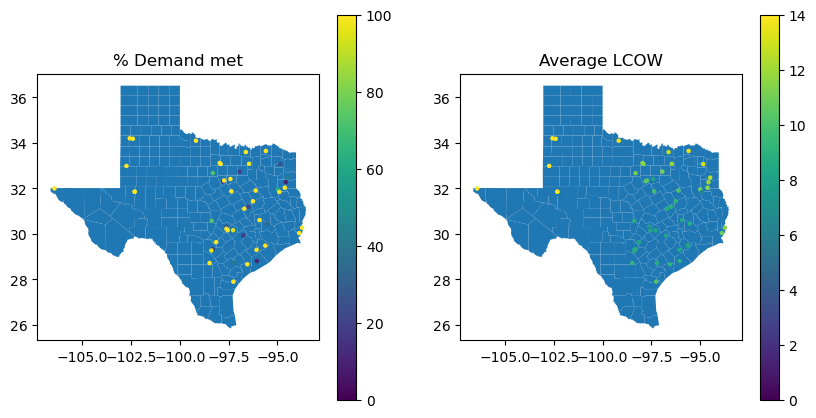

In [42]:
# pp_demand_met_df = one_pp_many_bw_df.groupby('PlantCode').last()
pp_demand_met_df = one_pp_many_bw_df[one_pp_many_bw_df['Cum_PPDemandFracMet']<=100].groupby('PlantCode').last()

fig, (ax0,ax1) = plt.subplots(1,2, figsize = (10,5))
# states[states['NAME'] == 'Texas'].plot(ax=ax,figsize=(20, 20))
texas.plot(ax=ax0,figsize=(50, 50))
pp_geo_df.loc[pp_demand_met_df.index].plot(column = pp_demand_met_df['Cum_PPDemandFracMet'].values*100, ax=ax0, 
                                           markersize = 5,label='PP',legend=True,vmin=0, vmax=100)
ax0.set_title('% Demand met')

texas.plot(ax=ax1,figsize=(50, 50))
pp_geo_df.loc[pp_demand_met_df.index].plot(column = pp_demand_met_df['WeightedtLCOW'].values, 
                                           ax=ax1, markersize = 5,label='PP',legend=True,vmin=0,vmax=14)
ax1.set_title('Average LCOW')

In [66]:
pp_demand_met_df[127]

KeyError: 127

Map the maximum % demand that be potentially met with all brackish water sites
1. Assuming the tLCOW does not exceed maximum LCOW
2. Or 100% demand is met

TODO: In the cases where the adding an additional brackish water site excced maximum LCOW calculate additional fractional supply possible

In [38]:
plantcodes = list(one_pp_many_bw_df.groupby('PlantCode').groups.keys())
pp_geo_df.index = plantcodes


In [39]:
one_pp_many_bw_df[(one_pp_many_bw_df['Cum_PPDemandFracMet']<=1)].groupby('PlantCode').last()

,PPLatitude,PPLongitude,PPDemand,BWSites,BWLatitude,BWLongitude,BWAvailable,Distance_km,PPDemandFracMet,LCOW,TransportLCOW,tLCOW,WeightedtLCOW,Cum_PPDemandFracMet
PlantCode,,,,,,,,,,,,,,
127,34.08250,-99.1753,0.437331,NURE-OR11762,34.671000,-100.648000,0.058217,150.161618,0.133119,0.795405,3.964841,4.760246,3.278300,0.922410
298,31.42190,-96.2525,0.995631,NURE-OR8579,29.148000,-96.600000,0.444081,255.038051,0.446030,0.627108,2.369685,2.996793,2.886105,0.966353
3453,32.72310,-96.9358,61.254712,USGS-273154099284801,27.531961,-99.480316,0.009779,626.892590,0.000160,1.394735,43.667839,45.062574,11.080589,0.182909
3456,31.98359,-106.4320,0.340367,FETH-315940N1050840.1,31.994444,-105.144472,0.167690,121.432117,0.492675,0.682810,1.880202,2.563012,2.563012,0.492675
3457,30.43560,-95.5214,32.849312,NURE-OR10855,34.525000,-101.925000,0.009467,753.076844,0.000288,1.348313,53.464624,54.812937,8.753126,0.341074
3459,30.02420,-93.8780,0.350784,USGS-300400093591601,30.066879,-93.987953,0.041586,11.598705,0.118552,0.854780,0.454104,1.308885,1.229908,0.243275
3470,29.48280,-95.6311,116.394525,NURE-OR10855,34.525000,-101.925000,0.009467,816.073268,0.000081,1.348313,57.927218,59.275531,8.349136,0.096259
3485,34.16610,-102.4110,0.319687,NURE-OR11788,34.684000,-100.744000,0.058134,163.381699,0.181848,0.799547,4.317733,5.117281,4.847147,0.986444
3504,31.93985,-94.9898,18.314581,NURE-OR10855,34.525000,-101.925000,0.009467,705.969931,0.000517,1.348313,50.112996,51.461309,11.010314,0.611755


21


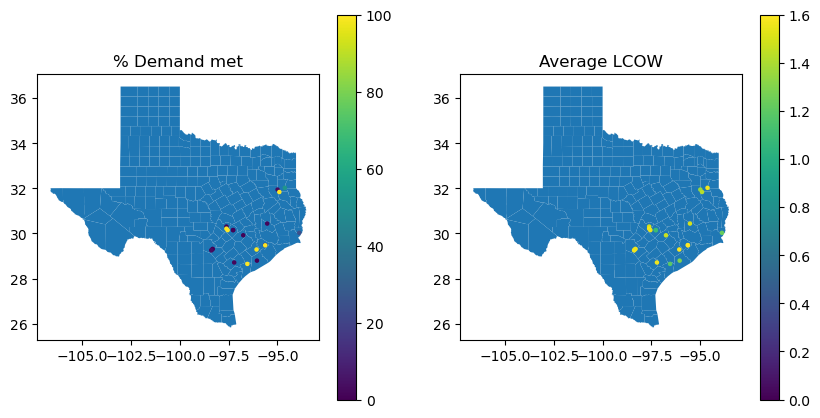

In [43]:
pp_demand_met_conditional_df = one_pp_many_bw_df[(one_pp_many_bw_df['Cum_PPDemandFracMet']<=100)& (one_pp_many_bw_df['WeightedtLCOW']<=max_LCOW)].groupby('PlantCode').last()

fig, (ax0,ax1) = plt.subplots(1,2, figsize = (10,5))
texas.plot(ax=ax0,figsize=(50, 50))
pp_geo_df.loc[pp_demand_met_conditional_df.index].plot(column = pp_demand_met_conditional_df['Cum_PPDemandFracMet'].values*100, ax=ax0,
                                                        markersize = 5, label='PP',legend=True,vmin=0,vmax = 100)
ax0.set_title('% Demand met')

texas.plot(ax=ax1,figsize=(50, 50))
pp_geo_df.loc[pp_demand_met_conditional_df.index].plot(column = pp_demand_met_conditional_df['WeightedtLCOW'].values,
                                                        ax=ax1, markersize = 5, label='PP',legend=True,vmin=0,vmax = 1.6)
ax1.set_title('Average LCOW')

print(len(pp_demand_met_conditional_df.index))

Function to find the most cost effect brackish water sites